In this notebook we will briefly cover the basics of the `pbmohpo` module implementing preferential Bayesian multi-objective hyperparameter optimization.
Core functionality is provided via the `run_pbmohpo_bench` function which takes a `YACS` configuration file specifying the benchmark problem looking like the following:

```yaml
PROBLEM:
  PROBLEM_TYPE: "yahpo"
  ID: "iaml_rpart"
  INSTANCE: "1067"
  OBJECTIVE_NAMES: ["auc", "nf"]
  OBJECTIVE_SCALING_FACTORS: [1, 21]

FIXED_HPS:
  TRAINSIZE: ("trainsize", 1)

BATCH_SIZE:
  EVAL_BATCH_SIZE: 2
  DM_BATCH_SIZE: 1

BUDGET:
  EVAL_BUDGET: 100
  DM_BUDGET: 100
```

This config file specifies the benchmark `PROBLEM` and allows for fixing certain hyperparamters of the search space (`FIXED_HPS`).

`pbmohpo` provides exemplarly config files in the `experiments_configs` directory.
We can proceed to use the above config file via:

In [1]:
from main import run_pbmohpo_bench
from config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file('./experiment_configs/templates/iaml_rpart_1067.yaml')
cfg.freeze()
print(cfg)

BATCH_SIZE:
  DM_BATCH_SIZE: 1
  EVAL_BATCH_SIZE: 2
BUDGET:
  DM_BUDGET: 100
  EVAL_BUDGET: 100
DECISION_MAKER:
  DECISION_MAKER_TYPE: DecisionMaker
  SEED: 123
FIXED_HPS:
  BOOSTER: (None, None)
  DEFINITION: (None, None)
  EPOCH: (None, None)
  NUM_IMPUTE_SELECTED_CPO: (None, None)
  PRE_POST: (None, None)
  REPL: (None, None)
  REPLACE: (None, None)
  RESPECT_UNORDERED_FACTORS: (None, None)
  SPLITRULE: (None, None)
  TRAINSIZE: ('trainsize', 1)
NAME:
  EXPERIMENT_NAME: PBMOHPO
OPTIMIZER:
  OPTIMIZER_TYPE: BO
PROBLEM:
  DIMENSIONS: 10
  ID: iaml_rpart
  INSTANCE: 1067
  OBJECTIVE_NAMES: ['auc', 'nf']
  OBJECTIVE_SCALING_FACTORS: [1, 21]
  OML_TASK: 359960
  PROBLEM_TYPE: yahpo
SEEDREPL: 0


We see that among `PROBLEM` and `FIXED_HPS` the resulting `YACS` config also includes parameters regarding the `BUDGET` and `OPTIMIZER` itself as well as the `DECISION MAKER`.
Running `run_pbmohpo_bench` on such a config will run the `OPTIMIZER` for the given `BUDGET` making use of the `DECISION_MAKER` to determine the utility function (i.e., in this example BO optimizing the utility scores provided by the decision maker for 100 function evaluation):

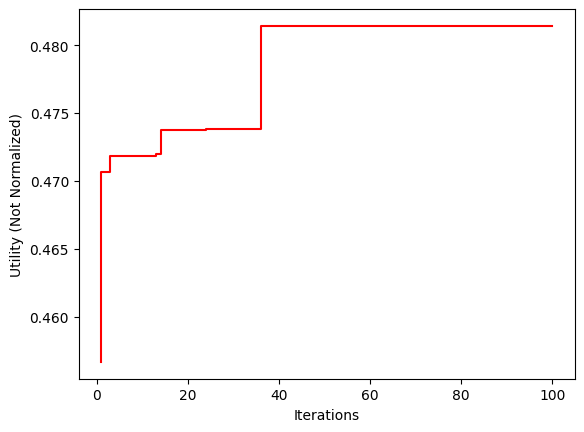

In [2]:
run_pbmohpo_bench(cfg, visualize=True)

We can see the optimization progress over time (which is also visualized in the figure).
We can easily compare this to a random search:

In [3]:
cfg.defrost()
cfg.merge_from_list(["OPTIMIZER.OPTIMIZER_TYPE", "RS"])
cfg.freeze()
print(cfg)

BATCH_SIZE:
  DM_BATCH_SIZE: 1
  EVAL_BATCH_SIZE: 2
BUDGET:
  DM_BUDGET: 100
  EVAL_BUDGET: 100
DECISION_MAKER:
  DECISION_MAKER_TYPE: DecisionMaker
  SEED: 123
FIXED_HPS:
  BOOSTER: (None, None)
  DEFINITION: (None, None)
  EPOCH: (None, None)
  NUM_IMPUTE_SELECTED_CPO: (None, None)
  PRE_POST: (None, None)
  REPL: (None, None)
  REPLACE: (None, None)
  RESPECT_UNORDERED_FACTORS: (None, None)
  SPLITRULE: (None, None)
  TRAINSIZE: ('trainsize', 1)
NAME:
  EXPERIMENT_NAME: PBMOHPO
OPTIMIZER:
  OPTIMIZER_TYPE: RS
PROBLEM:
  DIMENSIONS: 10
  ID: iaml_rpart
  INSTANCE: 1067
  OBJECTIVE_NAMES: ['auc', 'nf']
  OBJECTIVE_SCALING_FACTORS: [1, 21]
  OML_TASK: 359960
  PROBLEM_TYPE: yahpo
SEEDREPL: 0


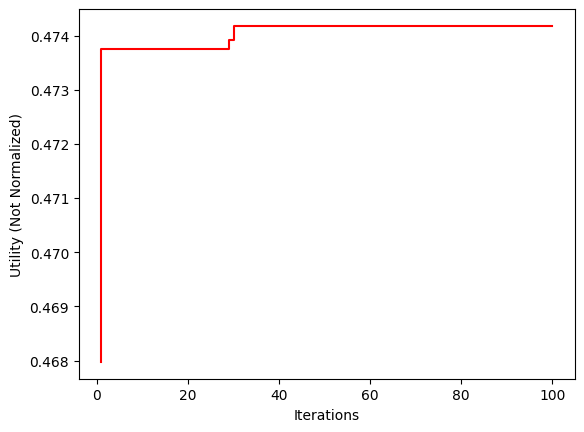

In [4]:
run_pbmohpo_bench(cfg, visualize=True)

`pbmohpo` also provides the `Benchmark` class that allows for working in a modular way relying on a `Problem`, an `Optimizer`, a `DecisionMaker` and a `budget` given as the number of function evaluations:

In [5]:
from pbmohpo.benchmark import Benchmark
from pbmohpo.problems.yahpo import YAHPO
from pbmohpo.optimizers.random_search import RandomSearch
from pbmohpo.decision_makers.decision_maker import DecisionMaker
from pbmohpo.utils import visualize_archives

fix_hps = {
    "trainsize": 1,
}
prob = YAHPO(id="iaml_rpart", instance="1067", objective_names=["auc", "nf"], fix_hps=fix_hps, objective_scaling_factors={"auc": 1, "nf": 21})

opt = RandomSearch(prob.get_config_space())

dm = DecisionMaker(objective_names=prob.get_objective_names())
print(dm.preferences)

{'auc': 0.2826175198582348, 'nf': 0.7173824801417652}


In [6]:
bench = Benchmark(prob, opt, dm, eval_budget=50, dm_budget=0)
bench.run()
best_eval = bench.archive.evaluations[bench.archive.incumbents[0]]
print(f"Best Configuration found in iteration [{bench.archive.incumbents[0]}]:")
print(best_eval)


Best Configuration found in iteration [3]:
Evaluation(config=Configuration(values={
  'cp': 0.002874133751538155,
  'maxdepth': 6,
  'minbucket': 80,
  'minsplit': 88,
})
, objectives={'auc': 0.7076151371002197, 'nf': -0.09523809523809523}, utility=0.1316622940955265)
